In [1]:
#################
#### IMPORTS ####
#################
import json, urllib.request
import pandas as pd
import numpy as np
import os
from pandas.io.json import json_normalize
from pandas import concat
from scipy import stats
import datetime
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from scipy.signal import argrelmin, argrelmax, butter, lfilter, freqz
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline


In [2]:
#######################
#### LOAD DATASETS ####
#######################

API_URL = 'https://api.mlab.com/api/1/databases/prototype/collections/'
API_KEY = 'XXX'

with urllib.request.urlopen(API_URL + 'Accelerometer?apiKey='+ API_KEY) as url:
    data_acc = json.loads(url.read().decode())
print("Loading ACC data from DB --> DONE")
with urllib.request.urlopen(API_URL + 'Gyroscope?apiKey=' + API_KEY) as url:
    data_gyr = json.loads(url.read().decode())
print("Loading GYR data from DB --> DONE")
with urllib.request.urlopen(API_URL + 'Magnetometer?apiKey=' + API_KEY) as url:
    data_mag = json.loads(url.read().decode())
print("Loading MAG data from DB --> DONE")
with urllib.request.urlopen(API_URL + 'GPS?apiKey=' + API_KEY) as url:
    data_gps = json.loads(url.read().decode())
print("Loading GPS data from DB --> DONE")
with urllib.request.urlopen(API_URL + 'activities?apiKey=' + API_KEY) as url:
    data_act = json.loads(url.read().decode())
print("Loading Activity data from DB --> DONE")

def createBackup():
    curDate = datetime.datetime.today().strftime('%Y-%m-%d')
    backupFolder = 'backup/'
    with open(backupFolder+curDate+'_acc.txt', 'w') as outfile:  
        json.dump(data_acc, outfile)
    with open(backupFolder+curDate+'_gyr.txt', 'w') as outfile:  
        json.dump(data_gyr, outfile)
    with open(backupFolder+curDate+'_mag.txt', 'w') as outfile:  
        json.dump(data_mag, outfile)
    with open(backupFolder+curDate+'_gps.txt', 'w') as outfile:  
        json.dump(data_gps, outfile)
    with open(backupFolder+curDate+'_act.txt', 'w') as outfile:  
        json.dump(data_act, outfile)
    

#createBackup()
act_id = [0, 1, 2, 3, 4, 5, 6, 7]
act_list = ['DUMMY', 'Bike', 'Car', 'Jogging', 'Metro', 'Tram', 'Train', 'Walking']
df_actList = pd.DataFrame({'activity_id':act_id, 'activity_list':act_list})
print(df_actList)
    
df_acc = pd.DataFrame(data_acc)
df_gyr = pd.DataFrame(data_gyr)
df_mag = pd.DataFrame(data_mag)
df_gps = pd.DataFrame(data_gps)

# Basic info about activities (id, start, stop, activityType)
# will get mapped with other sensor data at a later point
df_actBasic = pd.DataFrame(data_act) 

Loading ACC data from DB --> DONE
Loading GYR data from DB --> DONE
Loading MAG data from DB --> DONE
Loading GPS data from DB --> DONE
Loading Activity data from DB --> DONE
   activity_id activity_list
0            0         DUMMY
1            1          Bike
2            2           Car
3            3       Jogging
4            4         Metro
5            5          Tram
6            6         Train
7            7       Walking


In [3]:
### FOR COSMETIC REASONS ###
df_actBasic = df_actBasic.drop(['model', 'serialNumber', 'systemVersion'], axis = 1)

In [0]:
print(df_acc.head())

In [4]:
#########################
#### Rename ID field ####
#########################

def renameIdField(newDataFrame):
    for key, value in newDataFrame['_id'].iteritems():
        value_new = value.get('$oid')
        newDataFrame['_id'][key] = value_new
    return newDataFrame

df_acc = renameIdField(df_acc)
df_gyr = renameIdField(df_gyr)
df_mag = renameIdField(df_mag)
df_gps = renameIdField(df_gps)
df_actBasic = renameIdField(df_actBasic)

/Users/alhirz/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [5]:
#######################
#### SET temp VARs ####
#######################


# Defining temp arrays for filling with necessary data
# temp vars for Acc, Gyro, Magn
temp_x = []
temp_y = []
temp_z = []
temp_ts = []


# temp vars for gps data
temp_accuracy = []
temp_heading = []
temp_lat = []
temp_long = []
temp_speed = []
temp_timestamp = []

# temp var for mapping sensor data to defined Activity
temp_id = []
dict_act_id = dict(df_actBasic[['_id','definedActivity']].values)
dict_act_start = dict(df_actBasic[['_id','startTime']].values)
dict_act_end = dict(df_actBasic[['_id','endTime']].values)


In [6]:
##############################################
#### RESET temp data after each assigning ####
##############################################

def resetTempData():
    global temp_id, temp_x, temp_y, temp_z, temp_ts
    temp_id.clear(), temp_x.clear(), temp_y.clear(), temp_z.clear(), temp_ts.clear()    

In [7]:
#####################################################
#### EXTRACT from DF, SAVE it in temporary lists ####
#####################################################

def extractSensorData(dataFrame, isGpsData):
    for key, value in dataFrame['data'].iteritems():
        for idx, val in enumerate(value):
            for s, x in val.items():
                temp_id.append(dataFrame['_id'][key])
                if not (isGpsData):
                    temp_x.append(x.get('x'))
                    temp_y.append(x.get('y'))
                    temp_z.append(x.get('z'))
                    temp_ts.append(x.get('timestamp'))

                if (isGpsData):
                    temp_lat.append(x.get('latitude'))
                    temp_long.append(x.get('longitude'))
                    temp_timestamp.append(x.get('timestamp'))
                    temp_accuracy.append(x.get('accuracy'))
                    temp_heading.append(x.get('heading'))
                    temp_speed.append(x.get('speed'))

In [8]:
########################################
#### ADD temp data to new DataFrame ####
########################################

def addToDf(newDataFrame, isGpsData):   
    newDataFrame = pd.DataFrame(temp_id, columns=['activityId']) 
    if not (isGpsData):
        newDataFrame['timestamp'] = pd.Series(temp_ts)
        newDataFrame['x'] = pd.Series(temp_x)
        newDataFrame['y'] = pd.Series(temp_y)
        newDataFrame['z'] = pd.Series(temp_z)
    if (isGpsData):
        newDataFrame['lat'] = pd.Series(temp_lat)
        newDataFrame['long'] = pd.Series(temp_long)
        newDataFrame['timestamp'] = pd.Series(temp_timestamp)
        newDataFrame['accuracy'] = pd.Series(temp_accuracy)
        newDataFrame['heading'] = pd.Series(temp_heading)
        newDataFrame['speed'] = pd.Series(temp_speed)
           
    newDataFrame['definedActivity'] = newDataFrame.activityId.replace(dict_act_id)
    return newDataFrame

In [9]:
#################################
#### GENERATE new DataFrames ####
#################################

# Building Accelerometer Data
extractSensorData(df_acc)
df_acc_new = addToDf(df_acc, False).sort_values('timestamp')
resetTempData()
print('ACC done')

# Building Gyroscope Data
extractSensorData(df_gyr, False)
df_gyr_new = addToDf(df_gyr, False).sort_values('timestamp')
resetTempData()
print('GYR done')

# Building Magnetometer Data
extractSensorData(df_mag, False)
df_mag_new = addToDf(df_mag, False).sort_values('timestamp')
resetTempData()
print('MAG done')

# Building GPS Data
extractSensorData(df_gps, True)
df_gps_new = addToDf(df_gps, True).sort_values('timestamp')
resetTempData()
print('GPS done')

ACC done
GYR done
MAG done
GPS done


In [10]:
#######################################################################
###################### DROP 5s from Start & End #######################
#######################################################################

list_activities = df_acc_new['activityId'].unique()

def cropStartEnd(df_toCrop):
    df_cut = pd.DataFrame()
    for activity in list_activities:
        act_in_df = df_toCrop['activityId'] == activity
        df_cur_act = df_toCrop[act_in_df]
        
        crop_start = df_cur_act.index[:150]
        df_cur_act = df_cur_act.drop(crop_start)
        
        crop_end = df_cur_act.iloc[:-150]
        df_cur_act = crop_end
        
        df_cut = df_cut.append(df_cur_act)
    df_cut = df_cut.reset_index().drop('index', axis=1)
    print("Length ", len(df_toCrop), " | ", len(df_cut), " -> ", int(len(df_toCrop)-len(df_cut)))
    return df_cut
    
df_acc_cut = cropStartEnd(df_acc_new)
df_gyr_cut = cropStartEnd(df_gyr_new)
df_mag_cut = cropStartEnd(df_mag_new)

print("Amount of activities: ",len(list_activities))

Length  657990  |  633390  ->  24600
Length  662671  |  638071  ->  24600
Length  357616  |  333016  ->  24600
Amount of activities:  82


In [0]:
def overview_plot(activity):
    if activity==0:
        for c in range(1,8):
            plt.plot(df_acc_new[df_acc_new['definedActivity'] == int(c)]['magnitude'])
    else:
        plt.plot(df_acc_new[df_acc_new['definedActivity'] == int(activity)]['magnitude'])
    plt.title('magnitude of acc by activities')
    plt.ticklabel_format(axis='definedActivities', scilimit=(0,0))
    plt.legend(range(1,8))

In [0]:
#columns_to_drop = ['timestamp', 'activityId','index']
columns_to_drop = ['timestamp','index', 'definedActivity']


def plotActivity(df, act):
    act_in_df = df['activityId'] == act
    df_cur_act = df[act_in_df]
    df_cur_act = df_cur_act.reset_index().drop(columns_to_drop, axis=1)
    df_cur_act.plot(subplots = True,
                    figsize = (14,12)#,
                    #ylim = (min(df['x']), max(df['x']))
                   )

In [11]:
def butter_lowpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


order = 6
fs = 20
cutoff = 1

b, a = butter_lowpass(cutoff, fs, order)

def denoiseSensor(sensorDataFrame,outputFile):
    newDataFrame = sensorDataFrame
    #newDataFrame = pd.DataFrame()
    for q in ['x', 'y', 'z']:   
        filter_data = sensorDataFrame[q]
        
        filter_test_x = range(len(filter_data))
        filter_test_yL = butter_lowpass_filter(filter_data, cutoff, fs, order)
        
        f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False, figsize=(12,12))
        ax1.set_title('FFT Data transform: ' + q)
        ax1.plot(filter_test_x, filter_data, label='Original data')
        ax1.set_ylim([min(filter_data), max(filter_data)])
        
        ax2.plot(filter_test_x, filter_test_yL, label='Low Pass filter')
        plt.savefig("plots/"+outputFile+str(q)+"_noise.png")
        ax2.set_ylim([min(filter_data), max(filter_data)])

        plt.xlim(0, len(filter_data))
        f.subplots_adjust(hspace=0.1)
        
        newDataFrame[q] = filter_test_yL

    return newDataFrame

In [0]:
def testDenoise():
    w, h = freqz(b, a, worN=8000)
    plt.subplot(2, 1, 1)
    plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
    plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')
    plt.xlim(0, 2)
    plt.title("Lowpass Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()
    
testDenoise()

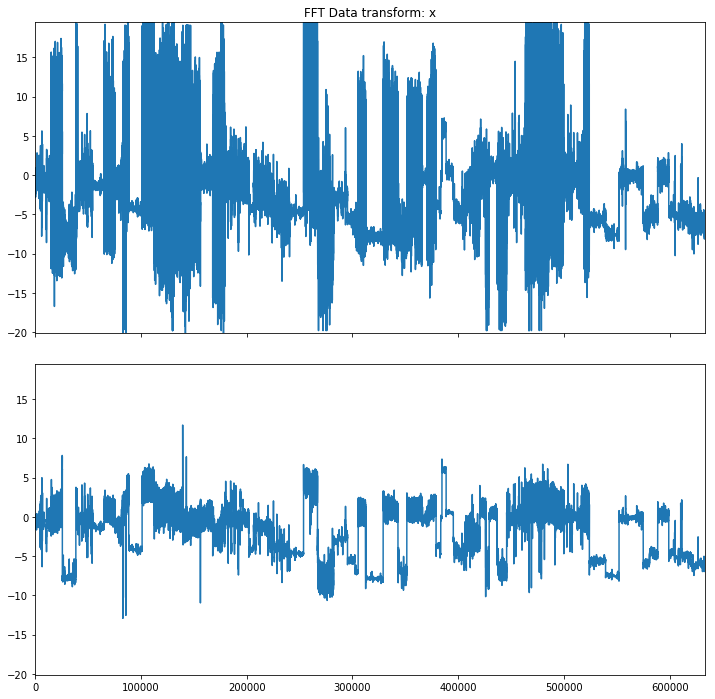

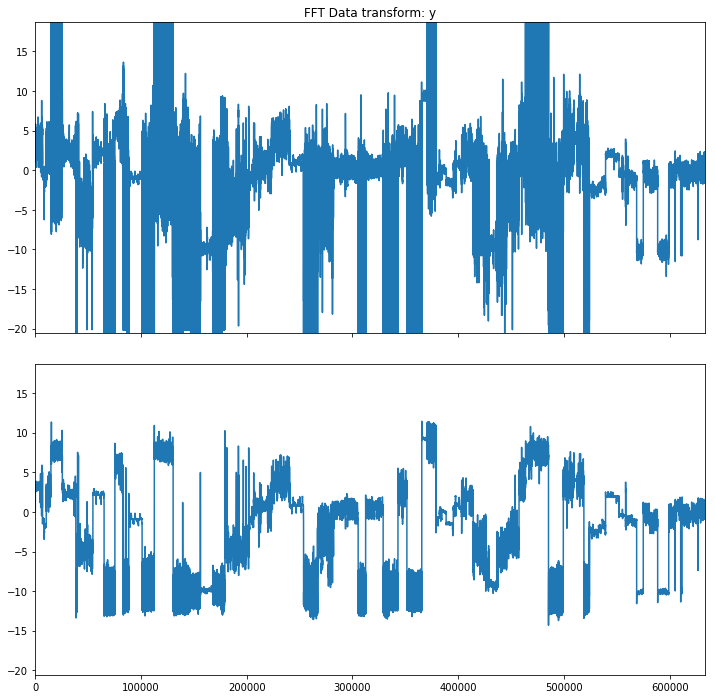

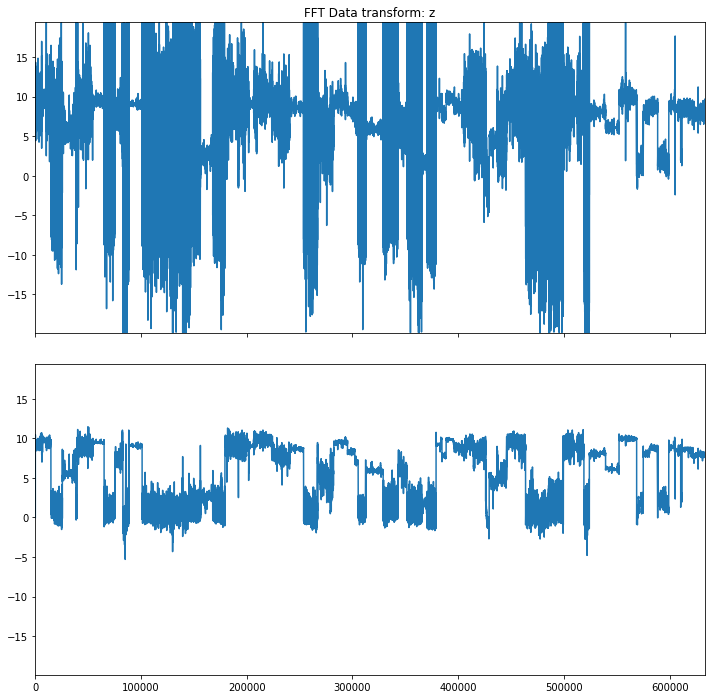

In [12]:
df_acc_denoise = denoiseSensor(df_acc_cut, 'ACC_')
df_gyr_denoise = df_gyr_cut
df_mag_denoise = df_mag_cut

In [13]:
def removeDuplicates(dfToCheck):
    duplicates_removed = dfToCheck.reset_index().drop_duplicates(subset='timestamp', keep='last')
    duplicated_removed = duplicates_removed.sort_values('timestamp')
    return duplicates_removed

In [0]:
############################################
######## SHOW Start/End timestamp ##########
############################################

actId = '5b8703421f6e4f79c187170e'

is_in_acc = df_acc_new['activityId'] == actId
filter_acc = df_acc_new[is_in_acc].sort_values('timestamp')

475829    1535574734633
Name: timestamp, dtype: int64 488148    1535575227405
Name: timestamp, dtype: int64
1535574849877 1535575227454


In [0]:
####################################################
####### SHOW DATA of specific activity ID  #########
####################################################

dataFrame = df_acc_cut
activity = '5b738e905d0e657bff269e7c'

df_act_in_sensor = dataFrame['activityId']==activity
df_filtered = dataFrame[df_act_in_sensor]

In [14]:
###############################
##### CALCULATE magnitude #####
###############################

def calcMagnitude(df):
    x2 = df['x']**2
    y2 = df['y']**2
    z2 = df['z']**2
    m2 = x2 + y2 + z2
    df['magnitude']=m2.apply(lambda x: np.sqrt(x))
    return df

In [15]:
df_acc_denoise = calcMagnitude(df_acc_denoise)
df_gyr_denoise = calcMagnitude(df_gyr_denoise)
df_mag_denoise = calcMagnitude(df_mag_denoise)

In [0]:
df_gyr_denoise.head(5)

In [19]:
##########################################
############## GPS Handling ##############
##########################################

df_gps_new = df_gps_new.drop(['lat', 'long', 'accuracy'], axis=1)

print(df_gps_new.head(10))


                  activityId      timestamp     heading      speed  \
0   5b65588f1f6e4f7b6b2accf5  1533368466000  211.399994  37.119999   
1   5b65588f1f6e4f7b6b2accf5  1533368467000  210.899994  37.220001   
2   5b65588f1f6e4f7b6b2accf5  1533368468000  210.500000  37.529999   
3   5b65588f1f6e4f7b6b2accf5  1533368469000  210.199997  37.740002   
42  5b66e3811f6e4f7b6b31435d  1533469570082  273.899994  11.130000   
43  5b66e3811f6e4f7b6b31435d  1533469572000  278.700012  11.310000   
44  5b66e3811f6e4f7b6b31435d  1533469573000  267.100006  11.190000   
45  5b66e3811f6e4f7b6b31435d  1533469574000  264.200012  11.030000   
46  5b66e3811f6e4f7b6b31435d  1533469576000  252.000000  11.000000   
47  5b66e3811f6e4f7b6b31435d  1533469577000  246.699997  11.200000   

    definedActivity  
0                 2  
1                 2  
2                 2  
3                 2  
42                2  
43                2  
44                2  
45                2  
46                2  
47       

In [40]:
################################
#### RESAMPLE & INTERPOLATE #### 
################################

def resampleData(dataFrame, isGPS, sensorType):
    if isGPS:
        sampleRate='5000L'
    else: sampleRate = '50L'
    
    debug = False
    list_activities = dataFrame['activityId'].unique()
    dataFrame_to_resample = pd.DataFrame()
    
    for activity in list_activities:
        df_act_in_sensor = dataFrame['activityId']==activity
        df_filtered = dataFrame[df_act_in_sensor]
        
        ## set start/end time from main activity (df_actBasic)
        ## necessary for consistency and further calculation
        df_filtered.head(1).timestamp = dict_act_start[activity]
        df_filtered.tail(1).timestamp = dict_act_end[activity]
        
        df_filtered = removeDuplicates(df_filtered)
        
        ## convert timestamp to DateTime and set it as an index
        df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'], unit='ms')
        df_filtered = df_filtered.set_index(['timestamp'])
        
        ## resample the data to 50ms/10s
        dataFrame_resampled = df_filtered\
            .select_dtypes(include=['float64', 'int64'])\
            .resample(sampleRate)\
            .bfill()\
            .interpolate(method='linear')
        dataFrame_to_resample = dataFrame_to_resample.append(dataFrame_resampled)
        
        if (debug):
            ##### KEEP FOR DEBUGGING PURPOSES #####
            #print(df_acc_resampled.plot(title = activity, figsize=(12,12)))
            #print(dataFrame_to_resample.head(1).index.values)
            #print(dataFrame_to_resample.tail(1).index.values)
            print(activity, " --> ",len(df_filtered), "|", len(dataFrame_resampled))
            #print("_________________________")
            ########################################
      
    print(len(dataFrame), " | ", len(dataFrame_to_resample), " (",(len(dataFrame_to_resample)-len(dataFrame)),")")
    dataFrame_to_resample.to_csv('datasets/'+sensorType+'_resampled.csv', sep='\t', encoding='utf-8')
    return dataFrame_to_resample

In [41]:
#df_acc_resampled = resampleData(df_acc_denoise, False, 'Accelerometer')
#df_gyr_resampled = resampleData(df_gyr_denoise, False, 'Gyroscope')
#df_mag_resampled = resampleData(df_mag_denoise, False, 'Magnetometer')

df_gps_resampled = resampleData(df_gps_new, True, 'GPS')

/Users/alhirz/anaconda3/envs/analysis/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


1518  |  5863  ( 4345 )


In [34]:
#df_acc_resampled = df_acc_resampled.drop('index', axis=1)
#df_gyr_resampled = df_gyr_resampled.drop('index', axis=1)
#df_mag_resampled = df_mag_resampled.drop('index', axis=1)
df_gps_resampled = df_gps_resampled.drop('index', axis=1)

In [24]:
df_acc_resampled.definedActivity = df_acc_resampled.definedActivity.astype(int)
df_gyr_resampled.definedActivity = df_gyr_resampled.definedActivity.astype(int)
df_mag_resampled.definedActivity = df_mag_resampled.definedActivity.astype(int)

In [0]:
#############################
#### FEATURE ENGINEERING ####
#############################


def slidingWindow(data, window_size, step_size):
    segments = []
    labels = []
    for i in range(0, len(data) - window_size, step_size):
        x_s = data['x'].values[i: i + window_size]
        y_s = data['y'].values[i: i + window_size]
        z_s = data['z'].values[i: i + window_size]
        m_s = data['magnitude'].values[i: i + window_size]
        label = stats.mode(data['definedActivity'][i: i + window_size])[0][0]
        segments.append([x_s, y_s, z_s, m_s, label])
    return segments

In [0]:
################################
####### REORDER COLUMNS# #######
################################

df_acc_resampled = df_acc_resampled[['x','y','z','magnitude','definedActivity']]
df_gyr_resampled = df_gyr_resampled[['x','y','z','magnitude','definedActivity']]
df_mag_resampled = df_mag_resampled[['x','y','z','magnitude','definedActivity']]


In [0]:
##########################################
##### PREPARE DATA FOR DEEP LEARNING #####
##########################################

df_deep = pd.concat([df_acc_resampled, df_gyr_resampled, df_mag_resampled], axis=1)

df_deep.columns = ['acc_x', 'acc_y', 'acc_z', 'acc_m', 'acc_Act', 
                  'gyr_x', 'gyr_y', 'gyr_z', 'gyr_m', 'gyr_Act', 
                  'mag_x', 'mag_y', 'mag_z', 'mag_m', 'activity']
df_deep = df_deep.drop(['acc_Act', 'gyr_Act'], axis=1)

print(df_deep.columns)

df_deep.to_csv('datasets/deep/dataset_resampled.csv', sep='\t', decimal=',', encoding='utf-8')

Index(['acc_x', 'acc_y', 'acc_z', 'acc_m', 'gyr_x', 'gyr_y', 'gyr_z', 'gyr_m',
       'mag_x', 'mag_y', 'mag_z', 'mag_m', 'activity'],
      dtype='object')


In [0]:
##########################################
####### generating SLIDING WINDOWs #######
##########################################


df_acc_metrics = df_acc_resampled
df_gyr_metrics = df_gyr_resampled
df_mag_metrics = df_mag_resampled


print(len(df_acc_metrics))
print(len(df_gyr_metrics))
print(len(df_mag_metrics))

win_acc = slidingWindow(df_acc_resampled, 40, 20)
win_gyr = slidingWindow(df_gyr_resampled, 40, 20)
win_mag = slidingWindow(df_mag_resampled, 40, 20)

df_window_acc = pd.DataFrame(win_acc, columns=['x','y','z','magnitude', 'activityType'])
df_window_gyr = pd.DataFrame(win_gyr, columns=['x','y','z','magnitude', 'activityType'])
df_window_mag = pd.DataFrame(win_mag, columns=['x','y','z','magnitude', 'activityType'])

print("------")
print(len(df_window_acc))
print(len(df_window_gyr))
print(len(df_window_mag))

df_window_acc_y = df_window_acc['activityType']
df_window_gyr_y = df_window_gyr['activityType']
df_window_mag_y = df_window_mag['activityType']

589724
589724
589724
------
29485
29485
29485


In [0]:
list_sensors = ['acc', 'gyr', 'mag']
list_xyz = ['x', 'y', 'z', 'magnitude']
list_agg = ['min', 'max', 'mean','std','var']

acc_feature = []
gyr_feature = []
mag_feature = []

list_fts_sensor = []
list_fts_all = []


for b in list_xyz:
    for c in list_agg:
        list_fts_sensor.append(b +"_" + c)

for a in list_sensors:
    for b in list_xyz:
        for c in list_agg:
            list_fts_all.append(a + "_"+ b +"_" + c)

In [0]:
def generateFeatures(dataFrame, sensor_feature):
    for row in dataFrame.itertuples():
        sensor_feature.append([
            row.x.min(),row.x.max(),row.x.mean(), row.x.std(), row.x.var(),
            row.y.min(),row.y.max(),row.y.mean(), row.y.std(), row.y.var(),
            row.z.min(),row.z.max(),row.z.mean(), row.z.std(), row.z.var(),
            row.magnitude.min(),row.magnitude.max(),row.magnitude.mean(), row.magnitude.std(),row.magnitude.var()
            ])    
    return dataFrame

In [0]:
#########################################
########## FEATURE ENGINEERING ##########
#########################################

generateFeatures(df_window_acc, acc_feature)
generateFeatures(df_window_gyr, gyr_feature)
generateFeatures(df_window_mag, mag_feature)

df_window_acc_ft = pd.DataFrame.from_records(acc_feature, columns=list_fts_sensor)
df_window_gyr_ft = pd.DataFrame.from_records(gyr_feature, columns=list_fts_sensor)
df_window_mag_ft = pd.DataFrame.from_records(mag_feature, columns=list_fts_sensor)

df_window_all = pd.concat([df_window_acc_ft, df_window_gyr_ft, df_window_mag_ft], axis=1)
df_window_all.columns = list_fts_all


In [0]:
########################################
########### NORMALIZING data ###########
########################################

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_window_all)
df_X_normalized = pd.DataFrame(np_scaled)
df_X_normalized = pd.get_dummies(df_X_normalized)

parameters1 = len(df_X_normalized.columns)

print(df_window_acc_y)
print(parameters1, parameters2)

0        2
1        2
2        2
3        2
4        2
5        2
6        2
7        2
8        2
9        2
10       2
11       2
12       2
13       2
14       2
15       2
16       2
17       2
18       2
19       2
20       2
21       2
22       2
23       2
24       2
25       2
26       2
27       2
28       2
29       2
        ..
29455    7
29456    7
29457    7
29458    7
29459    7
29460    7
29461    7
29462    7
29463    7
29464    7
29465    7
29466    7
29467    7
29468    7
29469    7
29470    7
29471    7
29472    7
29473    7
29474    7
29475    7
29476    7
29477    7
29478    7
29479    7
29480    7
29481    7
29482    7
29483    7
29484    7
Name: activityType, Length: 29485, dtype: int64
60 7


In [0]:
#######################################
######### SETTING THE COLUMNS #########
#######################################

df_X_normalized.columns = list_fts_all
df_y = pd.DataFrame(df_window_acc_y)
df_X = df_X_normalized
print(df_X.columns)
print(df_y.columns)


Index(['acc_x_min', 'acc_x_max', 'acc_x_mean', 'acc_x_std', 'acc_x_var',
       'acc_y_min', 'acc_y_max', 'acc_y_mean', 'acc_y_std', 'acc_y_var',
       'acc_z_min', 'acc_z_max', 'acc_z_mean', 'acc_z_std', 'acc_z_var',
       'acc_magnitude_min', 'acc_magnitude_max', 'acc_magnitude_mean',
       'acc_magnitude_std', 'acc_magnitude_var', 'gyr_x_min', 'gyr_x_max',
       'gyr_x_mean', 'gyr_x_std', 'gyr_x_var', 'gyr_y_min', 'gyr_y_max',
       'gyr_y_mean', 'gyr_y_std', 'gyr_y_var', 'gyr_z_min', 'gyr_z_max',
       'gyr_z_mean', 'gyr_z_std', 'gyr_z_var', 'gyr_magnitude_min',
       'gyr_magnitude_max', 'gyr_magnitude_mean', 'gyr_magnitude_std',
       'gyr_magnitude_var', 'mag_x_min', 'mag_x_max', 'mag_x_mean',
       'mag_x_std', 'mag_x_var', 'mag_y_min', 'mag_y_max', 'mag_y_mean',
       'mag_y_std', 'mag_y_var', 'mag_z_min', 'mag_z_max', 'mag_z_mean',
       'mag_z_std', 'mag_z_var', 'mag_magnitude_min', 'mag_magnitude_max',
       'mag_magnitude_mean', 'mag_magnitude_std', 'mag_magnit

In [0]:
#######################################
######### EXPORTING main data #########
#######################################


print(len(df_X))
print(len(df_y))

df_X.to_csv('datasets/X.csv', sep='\t', decimal=',', encoding='utf-8')
df_y.to_csv('datasets/y.csv', sep='\t', encoding='utf-8')

29485
29485


In [0]:
#print(df_X_normalized.head(1))
print(len(df_X))

29485


In [0]:
######################################
######### SPLITTING the data #########
######################################

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)

X_train.to_csv('datasets/X_train.csv', sep='\t', decimal=',', encoding='utf-8')
X_test.to_csv('datasets/X_test.csv', sep='\t', decimal=',', encoding='utf-8')
y_train.to_csv('datasets/y_train.csv', sep='\t', encoding='utf-8')
y_test.to_csv('datasets/y_test.csv', sep='\t', encoding='utf-8')

print(len(X_train))
print(len(X_test))

23588
5897


In [0]:
corr = df_X_normalized[df_X_normalized.columns].corr()
print(corr)

                    acc_x_min  acc_x_max  acc_x_mean  acc_x_std  acc_x_var  \
acc_x_min            1.000000  -0.300312    0.308473  -0.687721  -0.623398   
acc_x_max           -0.300312   1.000000    0.760530   0.861929   0.749529   
acc_x_mean           0.308473   0.760530    1.000000   0.427294   0.378086   
acc_x_std           -0.687721   0.861929    0.427294   1.000000   0.935804   
acc_x_var           -0.623398   0.749529    0.378086   0.935804   1.000000   
acc_y_min            0.337607  -0.646795   -0.383480  -0.542794  -0.313959   
acc_y_max           -0.435500   0.440824    0.209966   0.624594   0.685411   
acc_y_mean           0.006614  -0.227455   -0.154346  -0.048353   0.157534   
acc_y_std           -0.617595   0.879664    0.490477   0.954231   0.835386   
acc_y_var           -0.593486   0.835000    0.479691   0.945249   0.899491   
acc_z_min            0.566781  -0.803598   -0.427208  -0.818172  -0.649632   
acc_z_max           -0.217489   0.639182    0.465929   0.493036 

In [0]:
print(df_X_normalized.shape)

In [0]:
#####################################
#### EXPORT results to csv files ####
#####################################

df_acc_cut.to_csv('datasets/final_acc.csv', sep='\t', encoding='utf-8')
df_mag_cut.to_csv('datasets/final_mag.csv', sep='\t', encoding='utf-8')
df_gyr_cut.to_csv('datasets/final_gyr.csv', sep='\t', encoding='utf-8')
df_gps_new.to_csv('datasets/final_gps.csv', sep='\t', encoding='utf-8')

# Filter for null values in gps
#df_null = df_gps_new[df_gps_new['duration']==0]
#df_null.to_csv('datasets/gps_null.csv', sep='\t', encoding='utf-8')

# Filter for startTime=endTime (=> endTime not correctly set)
#df_no_duration = df_act[df_act['startTime'] == df_act['endTime']]
#df_no_duration.to_csv('datasets/final_no_duration.csv', sep='\t', encoding='utf-8')

#df_no_value = df_acc_new[df_acc_new['definedActivity'] == 7]

#df_no_value[['x','y','z']].to_csv('datasets/final_no_value.csv', sep='\t', encoding='utf-8')

In [0]:
################################
#### PLOT specific activity ####
################################

def plot_activity(activity, df):
    #data = df[df['activityId'] == activity][['x', 'y', 'z','magnitude']]
    data = df[df['definedActivity'] == activity][['x', 'y', 'z','magnitude']].reset_index().drop('index', axis=1)
    
    axis = data.plot(subplots=True,  
                     title=activity,
                    figsize=(14,12))
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

df_specAct = df_gyr_denoise
plot_activity(5, df_specAct)

# Create filter to only show a specific activity of a dataframe
df_isin_acc = df_acc_new['activityId']=='5b7bdc6d5d0e657f28c769d9'
df_acc_filtered = df_acc_new[df_isin_acc]

AxesSubplot(0.125,0.125;0.775x0.755)


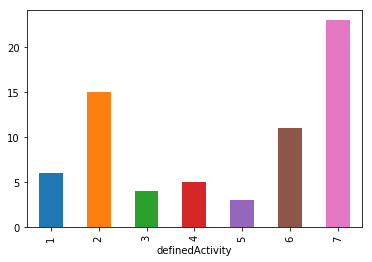

In [0]:
print(df_acc_cut.groupby('definedActivity')['activityId'].nunique().plot(kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)


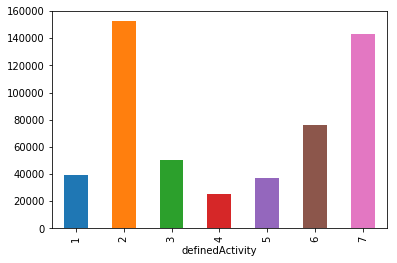

In [0]:
print(df_acc_cut.groupby('definedActivity')['activityId'].count().plot(kind='bar'))

In [0]:
               
                #################################################################
                #################################################################
                ##################### END OF USED STUFF #########################
                #################################################################
                #################################################################
                                            
                                            THE END

In [0]:
######################################################################################################################
######################################################################################################################
######################################################################################################################

In [0]:
##############################################
#### REMOVE Duplicates in dataframes #########
##############################################

#print(df_acc_new.groupby('activityId')['x'].apply(lambda x: x.count()))
def removeAllDuplicates():
    #is_duplicate_acc = df_acc_new['activityId'] == activity
    #is_duplicate_gyr = df_gyr_new['activityId'] == activity
    #is_duplicate_mag = df_mag_new['activityId'] == activity

    #filter_duplicate_acc = df_acc_new[is_duplicate_acc]
    #filter_duplicate_gyr = df_gyr_new[is_duplicate_gyr]
    #filter_duplicate_mag = df_mag_new[is_duplicate_mag]
    
    duplicates_removed_acc = df_acc_denoise.reset_index().drop_duplicates(subset='timestamp', keep='last')
    duplicates_removed_gyr = df_gyr_denoise.reset_index().drop_duplicates(subset='timestamp', keep='last')
    duplicates_removed_mag = df_mag_denoise.reset_index().drop_duplicates(subset='timestamp', keep='last')
    
    print("old/new ACC --> ",len(df_acc_denoise), " | ", len(duplicates_removed_acc))
    print("old/new GYR --> ",len(df_gyr_denoise), " | ", len(duplicates_removed_gyr))
    print("old/new MAG --> ",len(df_mag_denoise), " | ", len(duplicates_removed_mag))

    return duplicates_removed_acc, duplicates_removed_gyr, duplicates_removed_mag
#np.set_printoptions(threshold=np.inf)
#print(filter_duplicate.index, filter_duplicate.index.duplicated(keep=False))

#df_acc_denoise, df_gyr_denoise, df_mag_denoise = removeDuplicates()